# 데이터 전처리 성능 비교

## data1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from scipy.stats import boxcox
from scipy.special import boxcox1p

import tensorflow.keras as keras
import tensorflow as tf
import time

In [1]:
def data1_prepro(df1=None, train=False, onehot=True):
    '''
    data1 전처리 함수.

    args:
        train : 학습용으로 전처리할것인지
        onehot : 원핫인코딩 할것인지 타겟인코딩 할것인지 (False=타겟인코딩)
    
    returns:
        X_train, X_test, y_train, y_test : train=True인경우
        X : train=False인 경우
    '''
    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')
    te = TargetEncoder(target_type='continuous')
    te.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')

    # 컬럼 변환기2 : Sex te, 나머지 표준화
    data1_ct_te = make_column_transformer(
        (te, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_te.set_output(transform='pandas')

    if 'Rings' in df1:
        X = df1.drop(columns='Rings')   
        y = df1.Rings
    else:
        X = df1

    if train:
        # test비율 20%로
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42)
        if onehot:
            X_train = data1_ct_ohe.fit_transform(X_train)
            X_test = data1_ct_ohe.transform(X_test)
        else:
            X_train = data1_ct_te.fit_transform(X_train, y_train)
            X_test = data1_ct_te.transform(X_test)
        return X_train, X_test, y_train, y_test
    else:
        return X
    

X_train, X_test, y_train, y_test = data1_prepro(train=True)
X_train_te, X_test_te, y_train_te, y_test_te = data1_prepro(train=True, onehot=False)

model = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model2 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          verbose=False)

model2.fit(X_train_te, y_train_te,
          eval_set=[(X_test_te, y_test_te)],
          verbose=False)
''

''

In [2]:
# AE로 차원축소

def AE_feature_extraction(X):
    """
    오토인코더로 차원축소 7 => 4
    학습후에 인코더만 반환
    """
    # 7 => 4
    encoder = keras.models.Sequential([
        keras.layers.Dense(4, activation='relu')
        ]
    )
    # 4 => 7
    decoder = keras.models.Sequential([
        keras.layers.Dense(7, activation=None)
        ]
    )
    # 컴파일 : loss = mse, opt = adam
    AutoEncoder = keras.Sequential([encoder, decoder])
    AutoEncoder.compile(optimizer=keras.optimizers.Adam(0.01),
                        loss='mse')
    
    # 콜백 정의
    # reduce_lr : 학습이 잘 안되면(6 epochs) 학습률 감소
    # e_stop : 특정epoch이상 차도 없으면(12 epochs) 중단
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5, patience=6,
                                                     verbose=0, mode='auto')
    e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=12,
                                              restore_best_weights=True)
    # 학습
    hist = AutoEncoder.fit(X, X,
                           batch_size=32,
                           validation_split=.25,
                           epochs=200,
                           callbacks=[e_stop, reduce_lr],
                           verbose=0)
    
    # 오토인코더 train, val의 epoch별 loss확인
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='val')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    return encoder

encoder = AE_feature_extraction(X_train.iloc[:,3:])

In [21]:
X_train2 = np.hstack((X_train.iloc[:,:3], encoder.predict(X_train.iloc[:,3:], verbose=0)))
X_test2 = np.hstack((X_test.iloc[:,:3], encoder.predict(X_test.iloc[:,3:], verbose=0)))

model3 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model3.fit(X_train2, y_train,
           eval_set=[(X_test2, y_test)],
           verbose=False)
''

''

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)

X_train3 = pca.fit_transform(X_train.iloc[:,3:])
X_test3 = pca.transform(X_test.iloc[:,3:])

X_train3 = np.hstack((X_train.iloc[:,:3], X_train3))
X_test3 = np.hstack((X_test.iloc[:,:3], X_test3))

model4 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model4.fit(X_train3, y_train,
           eval_set=[(X_test3, y_test)],
           verbose=False)
''

''

In [131]:
# 혹시 모르니 skewness 조정된 버전도 실험

def data1_prepro_noskew(df1=None):

    if not df1:
        df1 = pd.read_csv('data/Regression_data.csv')

    num_cols = df1.drop(columns=['Sex', 'Rings']).columns
    cat_cols = ['Sex']

    # Height 이상치 클립 : 최대값 0.3
    df1.Height.clip(upper=0.3, inplace=True)

    # boxcox로 Sex, Ring제외 skewness 전부 조정
    temp = df1[num_cols].apply(lambda x: x+0.001).apply(lambda x: boxcox(x)[0])
    X = pd.concat([df1[cat_cols], temp], axis=1)
    y = df1.Rings

    # ohe 인경우 먼저 인코딩
    scaler = StandardScaler()
    scaler.set_output(transform='pandas')
    ohe = OneHotEncoder(sparse_output=False)
    ohe.set_output(transform='pandas')

    # 컬럼 변환기1 : Sex ohe, 나머지 표준화
    data1_ct_ohe = make_column_transformer(
        (ohe, cat_cols),
        (scaler, num_cols),
        remainder='passthrough'
    )
    data1_ct_ohe.set_output(transform='pandas')
    
    # test비율 20%로
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=40)
    
    X_train = data1_ct_ohe.fit_transform(X_train)
    X_test = data1_ct_ohe.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train4, X_test4, y_train4, y_test4 = data1_prepro_noskew()

model5 = XGBRegressor(n_estimators=500,
                     objective='reg:squarederror',
                     booster='gbtree',
                     max_depth=8,
                     learning_rate=0.01,
                     tree_method='gpu_hist',
                     gpu_id=0,
                     eval_metric='rmse',
                     early_stopping_rounds=20,
                     random_state=42)

model5.fit(X_train4, y_train4,
           eval_set=[(X_test4, y_test4)],
           verbose=False)
''

''

In [143]:
def cv(model, X_train, X_test, y_train, y_test):
    rmse =cross_val_score(model, X_train, y_train,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          fit_params={'eval_set':[(X_test, y_test)],
                                      'verbose':False,})

    rmse = np.sqrt(np.abs(rmse))
    return rmse

ohe_rmse = cv(model, X_train, X_test, y_train, y_test)
ohe_noskew_rmse = cv(model5, X_train4, X_test4, y_train4, y_test4)
te_rmse = cv(model2, X_train_te, X_test_te, y_train_te, y_test_te)
ae_rmse = cv(model3, X_train2, X_test2, y_train, y_test)
pca_rmse = cv(model4, X_train3, X_test3, y_train, y_test)

print(f'ohe cv rmse : {ohe_rmse}')
print(f'ohe cv noskew rmse : {ohe_noskew_rmse}')
print(f'te cv rmse : {te_rmse}')
print(f'ae cv rmse : {ae_rmse}')
print(f'pca cv rmse : {pca_rmse}\n')

print(f'ohe mean rmse : {np.mean(ohe_rmse)}')
print(f'ohe noskew mean rmse : {np.mean(ohe_noskew_rmse)}')
print(f'te mean rmse : {np.mean(te_rmse)}')
print(f'ae mean rmse : {np.mean(ae_rmse)}')
print(f'pca mean rmse : {np.mean(pca_rmse)}')

# xgboost가 공선성에 강하므로 AE, PCA를 통한 feature extraction은 큰 의미는 없는것 같다.
# 마찬가지로 skewness를 없애고 진행해도 결과차이는 크지 않다.


ohe cv rmse : [2.0640369  2.29157908 2.29728733 2.17979154 2.00275552]
ohe cv noskew rmse : [2.19021825 2.2022373  2.21177252 2.15222797 2.219526  ]
te cv rmse : [2.07481908 2.31469053 2.29444519 2.16152719 2.05606906]
ae cv rmse : [2.16315881 2.44069981 2.43922467 2.28064144 2.11798293]
pca cv rmse : [2.13613558 2.42536024 2.32408536 2.27655981 2.10901572]

ohe mean rmse : 2.167090074629537
ohe noskew mean rmse : 2.1951964094506162
te mean rmse : 2.1803102090912247
ae mean rmse : 2.288341532186832
pca mean rmse : 2.2542313412077624


In [15]:
# 신경망도 사용해보기
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.cache().shuffle(3500).batch(32)
valid_ds = valid_ds.cache().shuffle(1000).batch(32)

l1 = tf.keras.regularizers.l1(1e-4)

nn = keras.models.Sequential([
    keras.layers.Dense(64, input_shape=[10,],
                       kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(32, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(16, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(8, kernel_regularizer=l1),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1),
])

nn.compile(optimizer=keras.optimizers.Adam(0.01),
           loss='mse')

# 콜백 정의
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.5, patience=6,
                                                     verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=12,
                                            restore_best_weights=True)

# hist = nn.fit(train_ds,
#               validation_data=valid_ds,
#               epochs=200,
#               callbacks=[reduce_lr, e_stop],
#               verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

In [34]:
print(f'nn rmse : {np.sqrt(nn.evaluate(X_test, y_test, verbose=0)):.3f}')

# 아무래도 신경망이다보니 튜닝안된 xgboost보단 성능이 좋은편

nn rmse : 2.122


## data1 전처리 요약
* Height 이상치 처리
* Sex 원핫인코딩, 혹은 타겟인코딩
* 수치형 변수 skewness조정시도
* 수치형 변수들 표준화
* 두가지 차원축소 방법 채택 (AE, PCA)
---
결과
* ohe, te, ae, pca 쓴 결과들이 전부 비슷하다.  
* skewness조정한것과 안한것의 차이거의없다.

    => 전처리에서 더 할게 있나??

## data2

In [2]:
df2 = pd.read_csv('data/binary_classification_data.csv')

# row 갯수 비교적 많음
# 상관계수는 별문제 없음. 2개세트만 좀 큰듯?
# 클래스불균형 심함 (0:~91%, 1:~9%)
#   * 레거시코드에선 target_class 1 단순 오버샘플링만 한듯?
# 이상치 있는 컬럼 3개
# 바이올린플롯 확인결과 아웃라이어 밴드중에 1이 많은 경우가 좀 있다.
#   => 일단 이상치 제거 없이 진행

X = df2.drop(columns='target_class')
y = df2.target_class
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.25,
                                                    stratify=y,
                                                    random_state=42)

# 표준화
scaler = StandardScaler()
scaler.set_output(transform='pandas')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = train_ds.cache().shuffle(14000).batch(32)
valid_ds = valid_ds.cache().shuffle(5000).batch(32)

In [115]:
b_model1 = XGBClassifier(objective='binary:logistic',
                         n_estimators=1000,
                         learning_rate=0.05,
                         max_depth=10,
                         early_stopping_rounds=20,
                         colsample_bytree=0.7,
                         eval_metric='aucpr',
                         scale_pos_weight=10,
                         reg_lambda=5,
                         tree_method='gpu_hist',
                         gpu_id=0,
                         random_state=41)


b_model1.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             verbose=100)

print(classification_report(y_test, b_model1.predict(X_test),digits=4))
# 기본결과

[0]	validation_0-aucpr:0.84769


[100]	validation_0-aucpr:0.93097
[111]	validation_0-aucpr:0.93062
              precision    recall  f1-score   support

           0     0.9899    0.9857    0.9878      4065
           1     0.8642    0.9000    0.8817       410

    accuracy                         0.9779      4475
   macro avg     0.9270    0.9429    0.9348      4475
weighted avg     0.9784    0.9779    0.9781      4475



In [114]:
X2 = X.apply(np.log)
print(X2.skew())
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y,
                                                        test_size=.25,
                                                        stratify=y,
                                                        random_state=42)


b_model2 = XGBClassifier(objective='binary:logistic',
                         n_estimators=1000,
                         learning_rate=0.05,
                         max_depth=10,
                         early_stopping_rounds=20,
                         colsample_bytree=0.7,
                         eval_metric='aucpr',
                         scale_pos_weight=10,
                         reg_lambda=5,
                         tree_method='gpu_hist',
                         gpu_id=0,
                         random_state=41)


b_model2.fit(X_train2, y_train2,
             eval_set=[(X_test2, y_test2)],
             verbose=100)

print(classification_report(y_test2, b_model2.predict(X_test2),digits=4))
# 로그변환으로 왜도를 낮춰도 성능에 별 변화가 없다. (약간 하락)

 Mean of the integrated profile                 -3.555214
 Standard deviation of the integrated profile   -0.533652
 Excess kurtosis of the integrated profile      -0.402860
 Skewness of the integrated profile              0.011625
 Mean of the DM-SNR curve                        1.378879
 Standard deviation of the DM-SNR curve          0.959045
 Excess kurtosis of the DM-SNR curve            -2.835663
 Skewness of the DM-SNR curve                   -1.834078
dtype: float64
[0]	validation_0-aucpr:0.85358


[100]	validation_0-aucpr:0.92907
[118]	validation_0-aucpr:0.92873
              precision    recall  f1-score   support

           0     0.9891    0.9847    0.9869      4065
           1     0.8551    0.8927    0.8735       410

    accuracy                         0.9763      4475
   macro avg     0.9221    0.9387    0.9302      4475
weighted avg     0.9769    0.9763    0.9765      4475



In [124]:
# 랜덤포레스트성능도 확인
from sklearn.ensemble import RandomForestClassifier

b_model3 = RandomForestClassifier(n_estimators=300,
                              criterion='entropy',
                              max_depth=9,
                              n_jobs=-1,
                              random_state=42)

b_model3.fit(X_train, y_train)
print(classification_report(y_test, b_model3.predict(X_test), digits=4))
# 랜덤포레스트도 성능은 별차이 없다.

              precision    recall  f1-score   support

           0     0.9849    0.9931    0.9890      4065
           1     0.9255    0.8488    0.8855       410

    accuracy                         0.9799      4475
   macro avg     0.9552    0.9209    0.9372      4475
weighted avg     0.9794    0.9799    0.9795      4475



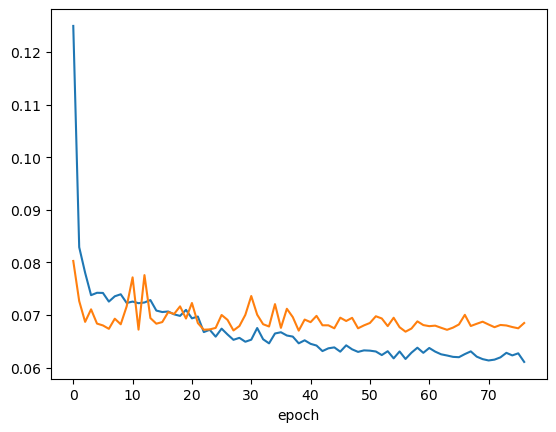

In [10]:
# 업샘플링 시도: SMOTE, ADASYN
# 모델은 앞으로 신경망을 쓰는걸로 결정


# 우선 기본모델부터
b_model4 = tf.keras.Sequential([
    keras.layers.Dense(64, input_shape=[8,]),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(32),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(8),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dense(1, activation='sigmoid')
])
b_model4.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.01))

# 콜백 재정의
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5, patience=10,
                                                 verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=20,
                                          restore_best_weights=False)
hist = b_model4.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [11]:
def prec_recall(model, X_test, y_test):
    precision, recall, th = precision_recall_curve(y_test, model.predict(X_test, verbose=False),
                                                   pos_label=1)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    best = np.argmax(f1)
    return precision[best], recall[best], f1[best], th[best]


_, recall, f1, th = prec_recall(b_model4, X_test, y_test)

print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')

recall : 0.878
f1 : 0.887
th : 0.399


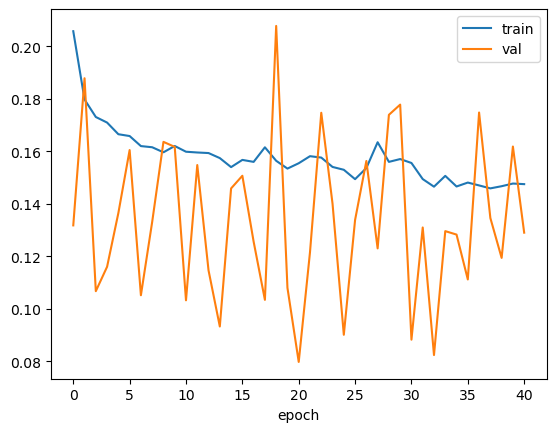

In [8]:
# SMOTE 
from imblearn.over_sampling import SMOTE

X_train2, y_train2 = SMOTE(random_state=42, k_neighbors=5).fit_resample(X_train, y_train)
train_ds2 = tf.data.Dataset.from_tensor_slices((X_train2, y_train2))
train_ds2 = train_ds2.cache().shuffle(28000).batch(32)


b_model5 = keras.models.clone_model(b_model4)
b_model5.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model5.fit(train_ds2,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [9]:
_, recall, f1, th = prec_recall(b_model5, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# SMOTE 돌릴때마다 결과가 다르다. 사실상 기본과 큰차이 없는듯?

recall : 0.861
f1 : 0.887
th : 0.854


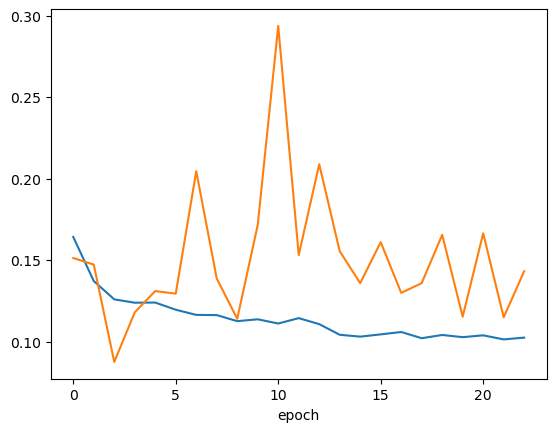

In [30]:
# SMOTEENN
from imblearn.combine import SMOTEENN

X_train3, y_train3 = SMOTEENN().fit_resample(X_train, y_train)
train_ds3 = tf.data.Dataset.from_tensor_slices((X_train3, y_train3))
train_ds3 = train_ds3.cache().shuffle(28000).batch(32)

b_model6 = keras.models.clone_model(b_model4)
b_model6.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model6.fit(train_ds3,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [31]:
_, recall, f1, th = prec_recall(b_model6, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# SMOTEENN도 f1살짝 증가. 리콜은 비슷

recall : 0.871
f1 : 0.894
th : 0.618


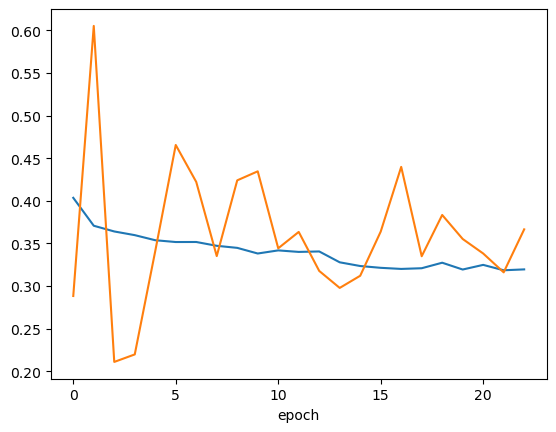

In [34]:
# ADASYN
from imblearn.over_sampling import ADASYN

X_train5, y_train5 = ADASYN(n_neighbors=5).fit_resample(X_train, y_train)
train_ds4 = tf.data.Dataset.from_tensor_slices((X_train5, y_train5))
train_ds4 = train_ds4.cache().shuffle(28000).batch(32)

b_model7 = keras.models.clone_model(b_model4)
b_model7.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model7.fit(train_ds4,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [35]:
_, recall, f1, th = prec_recall(b_model7, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# ADASYN역시 f1살짝증가 . 리콜은 감소.
# n_neighbors를 늘리면 : f1비슷. 리콜감소..

recall : 0.841
f1 : 0.893
th : 0.930


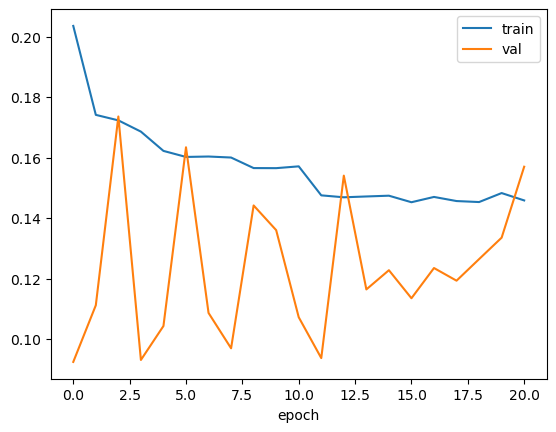

In [15]:
# SMOTETomek : SMOTE와 더불어 소수 클래스와 인접한 다수클래스 삭제
# => 결정경계를 명확히 구분시키는 효과가 있다.
from imblearn.combine import SMOTETomek

X_train6, y_train6 = SMOTETomek().fit_resample(X_train, y_train)
train_ds5 = tf.data.Dataset.from_tensor_slices((X_train6, y_train6))
train_ds5 = train_ds5.cache().shuffle(28000).batch(32)

b_model8 = keras.models.clone_model(b_model4)
b_model8.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model8.fit(train_ds5,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [16]:
_, recall, f1, th = prec_recall(b_model8, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# SMOTETomek : f1비슷, 리콜 크게감소. 고려할 이유 없는듯

recall : 0.846
f1 : 0.889
th : 0.954


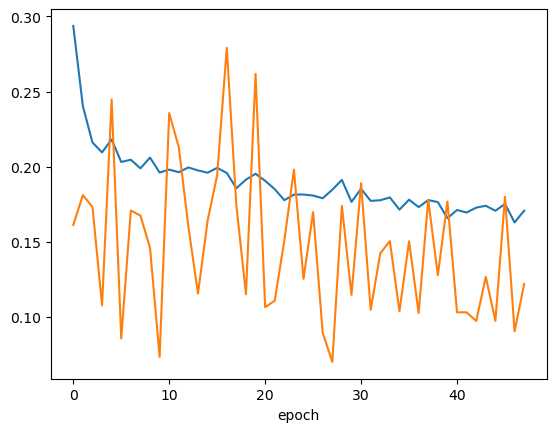

In [20]:
# 오버샘플링 없이 가중치만 설정해서 교육
weight0 = (1 / y_train.value_counts()[0]) * (y_train.shape[0] / 2.0)
weight1 = (1 / y_train.value_counts()[1]) * (y_train.shape[0] / 2.0)
c_weight = {0:weight0, 1:weight1}

b_model9 = keras.models.clone_model(b_model4)
b_model9.compile(loss='binary_crossentropy',
                 metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'

hist = b_model9.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    class_weight=c_weight,
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [22]:
_, recall, f1, th = prec_recall(b_model9, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# class_weight조정 : 리콜감소, f1 비슷.. 

recall : 0.846
f1 : 0.889
th : 0.846


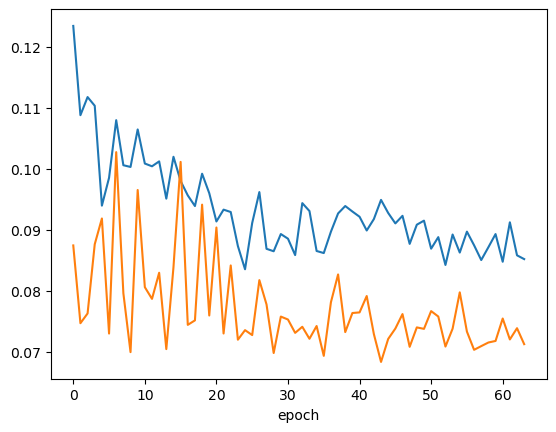

In [27]:
# 코스트 센시티브 학습
def weighted_bce(y_true, y_pred):
    bce = keras.losses.BinaryCrossentropy()
    loss = bce(y_true, y_pred)
    weight_vector = tf.where(y_true == 1, 5.461, 0.550)
    loss = loss * weight_vector
    return tf.reduce_mean(loss)

b_model10 = keras.models.clone_model(b_model4)
b_model10.compile(loss=weighted_bce,
                 metrics='accuracy',
                 optimizer=keras.optimizers.Adam(0.1))

e_stop.monitor = 'val_loss'
reduce_lr.monitor = 'val_loss'
e_stop.restore_best_weights = True

hist = b_model10.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    class_weight=c_weight,
                    verbose=0)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.show()

In [33]:
_, recall, f1, th = prec_recall(b_model10, X_test, y_test)
print(f'recall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')
# 코스트 센시티브 : f1 소폭증가, 리콜감소

recall : 0.856
f1 : 0.889
th : 0.534


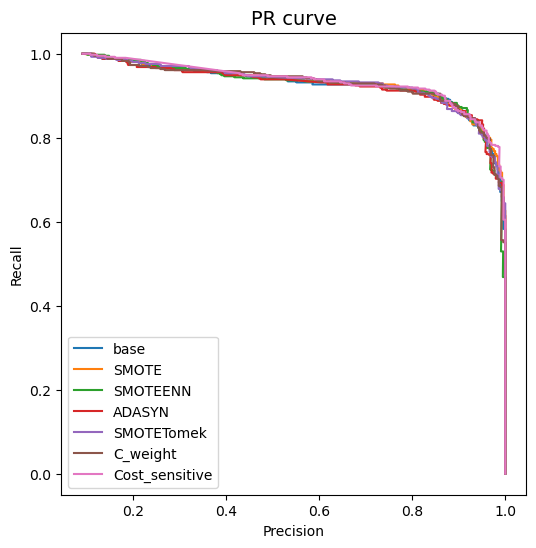

In [47]:
# 각 샘플링기법 AUCPR 생성
models = dict(zip(['base', 'SMOTE', 'SMOTEENN', 'ADASYN', 'SMOTETomek', 'C_weight', 'Cost_sensitive'],
                  [b_model4, b_model5, b_model6, b_model7, b_model8, b_model9, b_model10]))

plt.figure(figsize=(6,6))
for name, model in models.items():
    precision, recall, _ = precision_recall_curve(
        y_test,
        model.predict(X_test, verbose=False),
        pos_label=1
    )
    plt.plot(precision, recall, label=name)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR curve', fontsize=14)
plt.legend()
plt.show()

## data2 전처리 요약
* 오버샘플링 혹은 클래스 가중치 조정에따른 효과가 크지 않다.
* 최대 f1은 살짝 향상되는편이고, 리콜은 분산이 너무 심하다.
* 그나마 f1도 높고 리콜도 안떨어지는게 SMOTEENN
* random_stat 변화에 따라 기본모델 성능이 0.87~0.894까지 다양하다.  
=> SMOTEENN쓰거나, 아니면 아예 안써도 될듯.

## data3